# CIFAR-10 Python - Kaggle

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as T
from torchvision import datasets
import os
import time
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

## Preparing DataLoaders

In [3]:
train_transform = T.Compose([
    T.RandomHorizontalFlip(p=.40),
    T.RandomRotation(30),
    T.ToTensor(),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

def get_data_loaders(train_t, test_t, batch_size=32, num_workers=0, shuffle=True):
    
    
    train_data = torchvision.datasets.CIFAR10(root=".", train=True,
                                             download=True, transform=train_t)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    
    
    test_data = torchvision.datasets.CIFAR10(root=".", train=False,
                                         download=True, transform=test_t)
    test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
    
    return train_loader, test_loader

In [4]:
trainloader, testloader = get_data_loaders(train_transform, test_transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [5]:
classes_dict = {0 : 'airplane', 
                1 : 'automobile', 2: 'bird', 3 : 'cat', 
                4 : 'deer', 5: 'dog', 6:'frog', 
                7 : 'horse', 8 : 'ship', 9 : 'truck'}

## Building Model

In [6]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        inner_channel = 4 * growth_rate
        
        self.bottle_neck = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels, inner_channel, kernel_size = 1, bias = False),
            nn.BatchNorm2d(inner_channel),
            nn.ReLU(inplace = True),
            nn.Conv2d(inner_channel, growth_rate, kernel_size = 3, padding = 1, bias = False)
        )
        
    def forward(self, x):
        return torch.cat([x, self.bottle_neck(x)], 1)
    
class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.down_sample = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, 1, bias = False),
            nn.AvgPool2d(2, stride = 2)
        )
        
    def forward(self, x):
        return self.down_sample(x)

    
class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate = 12, reduction = 0.5, num_class = 10):
        super().__init__()
        self.growth_rate = growth_rate
        
        inner_channels = 2 * growth_rate
        
        self.conv1 = nn.Conv2d(3, inner_channels, kernel_size = 3, padding = 1, bias = False)
        self.features = nn.Sequential()
        
        for index in range(len(nblocks) - 1):
            self.features.add_module('dense_block_layer_{}'.format(index), self._make_dense_layers(block, inner_channels, nblocks[index]))
            inner_channels += growth_rate * nblocks[index]
            
            out_channels = int(reduction * inner_channels)
            
            self.features.add_module('transition_layer_{}'.format(index), Transition(inner_channels, out_channels))
            inner_channels = out_channels
            
        self.features.add_module('dense_block{}'.format(len(nblocks) - 1), self._make_dense_layers(block, inner_channels, nblocks[len(nblocks) - 1]))
        inner_channels += growth_rate * nblocks[len(nblocks) - 1]
        self.features.add_module('bn', nn.BatchNorm2d(inner_channels))
        self.features.add_module('activation', nn.ReLU(inplace = True))
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.linear = nn.Linear(inner_channels, num_class)
        
    def forward(self, x):
        output = self.conv1(x)
        output = self.features(output)
        output = self.avgpool(output)
        output = output.view(output.size()[0], -1)
        output = self.linear(output)
        return output
    
    def _make_dense_layers(self, block, in_channels, nblocks):
        dense_block = nn.Sequential()
        for index in range(nblocks):
            dense_block.add_module('bottle_neck_layer_{}'.format(index), block(in_channels, self.growth_rate))
            in_channels += self.growth_rate
        return dense_block
    
def densenet121(activation = 'relu'):
    return DenseNet(Bottleneck, [6, 12, 24, 16], growth_rate = 32)

def densenet169(activation = 'relu'):
    return DenseNet(Bottleneck, [6, 12, 32, 32], growth_rate = 32)

def densenet201(activation = 'relu'):
    return DenseNet(Bottleneck, [6, 12, 48, 32], growth_rate = 32)

def densenet161(activation = 'relu'):
    return DenseNet(Bottleneck, [6, 12, 36, 24], growth_rate = 48)

In [7]:
epochs = 5
lr = 0.001
model = densenet121()

In [8]:
train_stats = pd.DataFrame(columns = ['Epoch', 'Time per epoch', 
                                      'Avg time per step', 'Train loss',
                                     'Train Accuracy', 
                                      'Train Top-3 Accuracy', 
                                      'Test Loss', 
                                      'Test Accuracy', 
                                      'Test Top-3 Accuracy'])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [9]:
model.to(device)

steps = 0
running_loss = 0
for epoch in range(epochs):
    
    since = time.time()
    
    train_accuracy = 0
    top3_train_accuracy = 0
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        np_top3_class = ps.topk(3, dim = 1)[1].cpu().numpy()
        target_numpy = labels.cpu().numpy()
        top3_train_accuracy += np.mean([1 if target_numpy[i] in np_top3_class[i] else 0 for i in range(0, len(target_numpy))])
    
    time_elapsed = time.time() - since
    
    test_loss = 0
    test_accuracy = 0
    top3_test_accuracy = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)
            
            test_loss += batch_loss.item()
            
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim = 1)
            equals = top_class == labels.view(*top_class.shape)
            test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            np_top3_class = ps.topk(3, dim = 1)[1].cpu().numpy()
            target_numpy = labels.cpu().numpy()
            top3_test_accuracy += np.mean([1 if target_numpy[i] in np_top3_class[i] else 0 for i in range(0, len(target_numpy))])
            
        print(f'Epoch {epoch+1} / {epochs}.. '
             f'Time per epoch : {time_elapsed:.4f}..'
             f'Average time per step : {time_elapsed/len(trainloader):.4f}..'
             f'Train loss : {running_loss/len(trainloader):.4f}..'
             f'Train Accuracy : {train_accuracy/len(trainloader):.4f}..'
             f'Top-3 train Accuracy : {top3_train_accuracy/len(trainloader):.4f}..'
             f'Test loss : {test_loss/len(testloader):.4f}..'
             f'Test Accuracy : {test_accuracy/len(testloader):.4f}..'
             f'Top-3 test Accuracy : {top3_test_accuracy/len(testloader):.4f}..')
        
        train_stats = train_stats.append({'Epoch' : epoch, 'Time per epoch' : time_elapsed, 'Avg time per step' : time_elapsed/len(trainloader),
                                         'Train loss' : running_loss/len(trainloader), 'Train accuracy' : train_accuracy/len(trainloader),
                                         'Train top-3 accuracy' : top3_train_accuracy/len(trainloader), 'Test loss' : test_loss/len(testloader),
                                         'Test accuracy' : test_accuracy/len(testloader), 'Test top-3 accuracy' : top3_test_accuracy/len(testloader)}, ignore_index = True)
        
        running_loss = 0
        model.train()

Epoch 1 / 5.. Time per epoch : 588.5239..Average time per step : 0.3765..Train loss : 1.5590..Train Accuracy : 0.4264..Top-3 train Accuracy : 0.7629..Test loss : 1.3045..Test Accuracy : 0.5388..Top-3 test Accuracy : 0.8336..
Epoch 2 / 5.. Time per epoch : 586.2432..Average time per step : 0.3751..Train loss : 1.1631..Train Accuracy : 0.5796..Top-3 train Accuracy : 0.8691..Test loss : 0.9386..Test Accuracy : 0.6682..Top-3 test Accuracy : 0.9130..
Epoch 3 / 5.. Time per epoch : 589.4126..Average time per step : 0.3771..Train loss : 0.9889..Train Accuracy : 0.6478..Top-3 train Accuracy : 0.9007..Test loss : 0.8617..Test Accuracy : 0.6932..Top-3 test Accuracy : 0.9251..
Epoch 4 / 5.. Time per epoch : 585.1671..Average time per step : 0.3744..Train loss : 0.8813..Train Accuracy : 0.6898..Top-3 train Accuracy : 0.9175..Test loss : 0.7881..Test Accuracy : 0.7202..Top-3 test Accuracy : 0.9378..
Epoch 5 / 5.. Time per epoch : 587.7517..Average time per step : 0.3760..Train loss : 0.7797..Train 

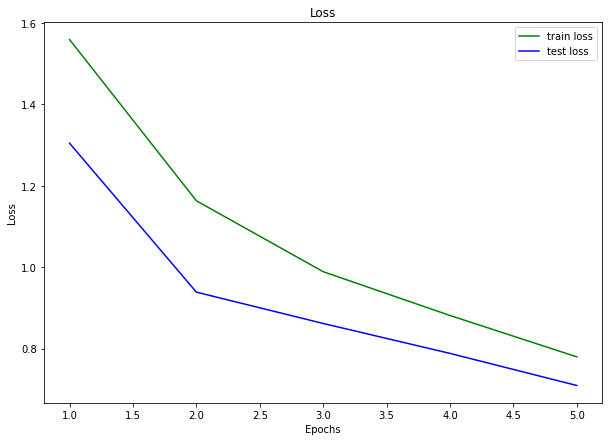

In [10]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes()

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

x = range(1, len(train_stats['Train loss'].values) + 1)
ax.plot(x, train_stats['Train loss'].values, '-g', label = 'train loss');
ax.plot(x, train_stats['Test loss'].values, '-b', label = 'test loss');

plt.legend()

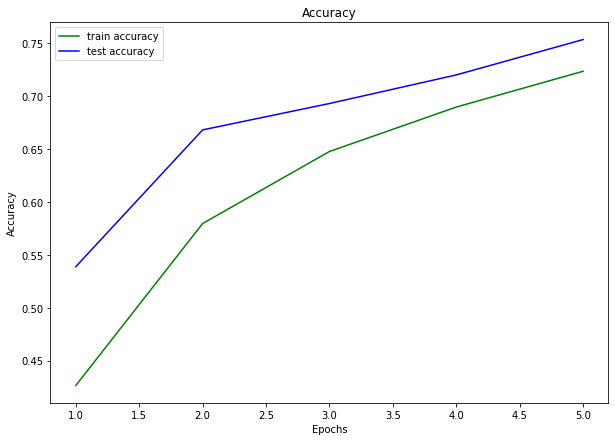

In [11]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes()

plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

x = range(1, len(train_stats['Train accuracy'].values) + 1)
ax.plot(x, train_stats['Train accuracy'].values, '-g', label = 'train accuracy');
ax.plot(x, train_stats['Test accuracy'].values, '-b', label = 'test accuracy');

plt.legend()
